In [1]:
%run util/installers.ipynb

Using TensorFlow backend.
util/installers.ipynb:44: UserWarning: You may need to refresh the notebook.
  "    except:\n",


### Representations of Words and Documents

* This section is about feature engineering schema for documents of text.
* How can we represent text in way that is useful for learning algorithms?
* Applications: 
    * Document classification
    * Document Retrieval    
    * Analogies
    * Language models
    * "Reverse Dictionaries"
    
* Methods we will cover:
    * Document Term Matrices
    * Weighting Schemes
    * Term-Context Matrices
    * Dimensionality Reduction (Latent Semantic Analysis)
    * Feature hashing
    * Neural embeddings    

### A note before starting...

* Word representation $\neq$ Document Representation
* Strategies for representing documents:
    * $\text{representation of document}$ 
        * N x K Matrix
        * Common with document retrieval, simple representation models.
    * $\text{aggregator(array of representations of words)}$ 
        * N x K Matrix    
        * Common with pre-trained word embeddings, document retrieval.
    * $\text{array of representations of words}$ 
        * N x M x K Matrix    
        * Common with Deep Learning Models.

### Success Criteria
* Performs well on the given task
* Similar words and documents are represented by points close in space.
* Few examples needed to learn
* Quick to learn/implement 
* Easy to store (low dimensional)
* Generalizes to new documents
* Generalizes to other tasks

### Simple Document Representation: Document Term Matrices:


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

    
verbs = ['like','likes','play','plays']
sports = ['baseball','soccer','football','golf','tennis']
pronouns = {
    'he':['plays','likes'],
    'she':['plays','likes'],
    'they':['play','like'],
    'we':['play','like'],
    'i':['play','like']
}

choose = lambda x: np.random.choice(x)

def build_clause():
    pronoun = choose(list(pronouns.keys()))
    verb = choose(pronouns[pronoun])
    sport = choose(sports)
    return " ".join([pronoun, verb, sport])
    
sentences = [build_clause() for i in range(20000)]


toDTM = CountVectorizer(lowercase=False)
DTM = toDTM.fit_transform(sentences).todense()
words = toDTM.get_feature_names()

dtm_summary = pd.DataFrame(DTM, columns = words, index = sentences)
dtm_summary.head()

,baseball,football,golf,he,like,likes,play,plays,she,soccer,tennis,they,we
we play golf,0,0,1,0,0,0,1,0,0,0,0,0,1
they play football,0,1,0,0,0,0,1,0,0,0,0,1,0
i like tennis,0,0,0,0,1,0,0,0,0,0,1,0,0
they play football,0,1,0,0,0,0,1,0,0,0,0,1,0
they like tennis,0,0,0,0,1,0,0,0,0,0,1,1,0


### Improving upon Counts with TFIDF
* Informative v noninformative words
* Weight words in a way that helps us distinguish documents.
* **TFIDF**: Weight words based on their frequency within a document, discounted by their frequency elsewhere.

In [3]:
#This example doesnt best show case tfidf...
from sklearn.feature_extraction.text import TfidfVectorizer
toTFIDF = TfidfVectorizer(lowercase=False)
TFIDF = toTFIDF.fit_transform(sentences).todense()
words = toTFIDF.get_feature_names()

tfidf_summary = pd.DataFrame(TFIDF, columns = words, index = sentences)
tfidf_summary.head()

,baseball,football,golf,he,like,likes,play,plays,she,soccer,tennis,they,we
we play golf,0.0,0.000000,0.607937,0.0,0.000000,0.0,0.512082,0.0,0.0,0.0,0.000000,0.000000,0.606782
they play football,0.0,0.605267,0.000000,0.0,0.000000,0.0,0.512596,0.0,0.0,0.0,0.000000,0.609013,0.000000
i like tennis,0.0,0.000000,0.000000,0.0,0.640028,0.0,0.000000,0.0,0.0,0.0,0.768352,0.000000,0.000000
they play football,0.0,0.605267,0.000000,0.0,0.000000,0.0,0.512596,0.0,0.0,0.0,0.000000,0.609013,0.000000
they like tennis,0.0,0.000000,0.000000,0.0,0.510081,0.0,0.000000,0.0,0.0,0.0,0.612351,0.604023,0.000000


* Popular for document representation
* Less common for word representation, in which people usually use PMMI.

### Challenge: We need to pass of the entire corpus before beginning

### Solution: Feature Hashing for faster (stateless) transformations
* Weinberger et al https://arxiv.org/pdf/0902.2206
* Solves the need to observe the whole dataset first to build a vocabulary dictionary.


* To vectorize a document:
    * Define number of dimensions K
    * Pick a hasher (MurmurHash3)
    * define F(word): hasher(word) % K
    * create empty vector V with K slots.
    * For word in document:
        * V[F(word)] += 1

* How many features to use?
    * Lots
    * Want to ensure 0 collisions

In [5]:
try:
    import mmh3
except:
    !pip install mmh3 >> ~/mmh3.log
from ipywidgets import Textarea, HBox, VBox, Button, IntSlider, Output
from IPython.display import display
from IPython.display import clear_output
import mmh3
import numpy as np

class Hasher(object):
    def __init__(self):
        self.textarea = Textarea("This is a document")
        self.slider = IntSlider(description="Number of Features", min=1, value=3)
        self.vectorize_button = Button(description="Vectorize")
        self.vectorize_button.on_click(self.vectorize)
        self.out = Output()
        self.stuff = VBox([self.textarea, self.slider, self.vectorize_button, self.out])
        display(self.stuff)
        
    @property
    def n_features(self):
        return self.slider.value
        
    @property
    def text(self):
        return self.textarea.value
    
    def hash_transform(self, word):
        return mmh3.hash(word) % self.n_features
    
    def vectorize(self, b):
        if self.text:
            
            vector = np.zeros(self.n_features)
            word_hash = {}
            with self.out:
                clear_output()
                for word in self.text.split(" "):
                    val = self.hash_transform(word)
                    word_hash[word] = val
                    vector[val] += 1
                n_collisions = len(word_hash.values()) - len(set(word_hash.values()))
                print("Hashing vectorizer with {0} features produced {1} collisions".format(self.n_features, n_collisions))
                print()
                print("Transformed Document:")
                print(vector)
                
        
c = Hasher()        

In [6]:
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer()
hashed_corpus = hv.transform(sentences)
hashed_corpus

<20000x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 55964 stored elements in Compressed Sparse Row format>

### Reducing High Dimensionality:
* Heap's law: $vocabsize = k\cdot ntokens^{\beta}$
    * K usually $\in$ (10, 100)
    * $\beta$ usually $\in$ (0.4, 0.6)
* Improve Generalizability
    * e.g. learning [sports] rather than baseball, basketball, etc...

/opt/conda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/envs/python3/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/opt/conda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


Size of vocabulary = 2.28*n_tokens^(0.80)


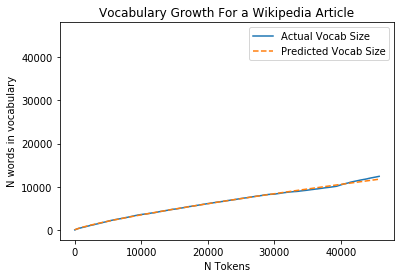

In [8]:
!pip install wikipedia >> ~/wikipedia.log
%matplotlib inline
import matplotlib.pyplot as plt
import wikipedia
import re
import numpy as np

page = wikipedia.page("List_of_Dutch_inventions_and_discoveries")
words = re.split("\s", page.content)


counts = []
for i in range(len(words)):
    counts.append(len(set(words[:i])))
counts = np.array(counts)

from scipy.optimize import minimize

def heap_error(arg):
    k, beta = arg
    heap_estimate = lambda x: k * x **(beta)
    predictions = np.array(list(map(heap_estimate, range(len(words)))))
    return np.mean(abs(predictions - counts))

optimal_params  = minimize(heap_error, (50, .5))
k, beta = optimal_params['x']
heap_estimate = lambda x: k * x **(beta)


f, ax = plt.subplots(1)
ax.plot(counts, label="Actual Vocab Size")
ax.set_ylim(ax.get_xlim())

predicted_word_counts = np.array(list(map(heap_estimate, range(len(words)))))
ax.plot(predicted_word_counts, linestyle="--", label='Predicted Vocab Size')
ax.set_xlabel("N Tokens")
ax.set_ylabel("N words in vocabulary")
ax.set_title("Vocabulary Growth For a Wikipedia Article")
plt.legend()
print("Size of vocabulary = {0:.2f}*n_tokens^({1:.2f})".format(k, beta))

In [9]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
k = 5
pca = PCA(n_components=k)
toDTM = CountVectorizer(lowercase=False)
DTM = toDTM.fit_transform(sentences).todense()
DTM_Rep = pca.fit_transform(DTM)
words = toDTM.get_feature_names()

lsa_summary = pd.DataFrame(DTM_Rep, columns = ['PCA {}'.format(i) for i in range(k)], index = sentences)
lsa_summary.head()

,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4
we play golf,-0.617189,-0.720543,0.256903,0.191524,0.916909
they play football,-0.634023,-0.705156,-0.902246,-0.135004,-0.582667
i like tennis,-0.300059,0.733241,-0.009822,0.153062,-0.119896
they play football,-0.634023,-0.705156,-0.902246,-0.135004,-0.582667
they like tennis,-0.592453,0.733723,-0.303702,0.543147,-0.539295


Related methods:
* Document Clustering
* LDA

### Simple Word Representation: Term-Term Matrices
* (Take the dot product of document term matrix with itself)

* A note on Word Representations:
    * first order (syntagmatic) association: They are typically nearby each other.
    * Second-order co-occurrence (paradigmatic association): They have similar neighbors.


In [25]:
term_term = pd.DataFrame(
    np.dot(DTM.T, DTM), 
    index = toDTM.get_feature_names(), 
    columns = toDTM.get_feature_names()
)
term_term

,baseball,football,golf,he,like,likes,play,plays,she,soccer,tennis,they,we
baseball,3926,0,0,760,1193,747,1203,783,770,0,0,800,828
football,0,4093,0,756,1252,753,1284,804,801,0,0,818,821
golf,0,0,4036,780,1174,814,1246,802,836,0,0,821,792
he,760,756,780,3855,0,1950,0,1905,0,796,763,0,0
like,1193,1252,1174,0,6038,0,0,0,0,1235,1184,1991,2003
likes,747,753,814,1950,0,3916,0,0,1966,805,797,0,0
play,1203,1284,1246,0,0,0,6082,0,0,1212,1137,2037,2053
plays,783,804,802,1905,0,0,0,3964,2059,807,768,0,0
she,770,801,836,0,0,1966,0,2059,4025,816,802,0,0
soccer,0,0,0,796,1235,805,1212,807,816,4059,0,806,857


#### PPMI Weighting

Probabilistic Indepedence: $P(A, B) = P(A)P(B)$

$\text{PMI}(x, y) = log_2\frac{P(x,y)}{P(x)P(y)}$

In [42]:
def ppmi(matrix):
    I, J = matrix.shape
    ppmi_matrix = np.ones((I, J))
    N = matrix.sum()
    marginals = matrix.diagonal() / N
    for i in range(I):
        for j in range(J):
            joint = matrix[i, j] / N
            marginal = marginals[i] * marginals[j]
            ppmi_matrix[i, j] = max(0, np.log2(joint / marginal))
    return ppmi_matrix
    

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
pd.DataFrame(
    ppmi(term_term.values),
    index = toDTM.get_feature_names(), 
    columns = toDTM.get_feature_names()
)

/opt/conda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.


,baseball,football,golf,he,like,likes,play,plays,she,soccer,tennis,they,we
baseball,5.347244,0.000000,0.000000,3.004584,3.007767,2.957043,3.009335,3.007371,2.961186,0.000000,0.000000,3.015252,3.054889
football,0.000000,5.287145,0.000000,2.936873,3.017309,2.908486,3.043245,2.985456,2.958031,0.000000,0.000000,2.987255,2.982542
golf,0.000000,0.000000,5.307378,3.002193,2.944740,3.041098,3.020136,3.002095,3.039964,0.000000,0.000000,3.012768,2.950893
he,3.004584,2.936873,3.002193,5.373573,0.000000,4.367667,0.000000,4.316407,0.000000,3.023289,3.025042,0.000000,0.000000
like,3.007767,3.017309,2.944740,0.000000,4.726233,0.000000,0.000000,0.000000,0.000000,3.009620,3.011617,3.709663,3.708338
likes,2.957043,2.908486,3.041098,4.367667,0.000000,5.350923,0.000000,0.000000,4.317198,3.016860,3.065289,0.000000,0.000000
play,3.009335,3.043245,3.020136,0.000000,0.000000,0.000000,4.715758,0.000000,0.000000,2.972024,2.942705,3.732141,3.733434
plays,3.007371,2.985456,3.002095,4.316407,0.000000,0.000000,0.000000,5.333347,4.366302,3.002863,2.994240,0.000000,0.000000
she,2.961186,2.958031,3.039964,0.000000,0.000000,4.317198,0.000000,4.366302,5.311315,2.996832,3.034704,0.000000,0.000000
soccer,0.000000,0.000000,0.000000,3.023289,3.009620,3.016860,2.972024,3.002863,2.996832,5.299180,0.000000,2.977968,3.056489


### What about local context?
* We've been treating words within a document as exchangeable, iid.

* We've been ignoring word context:
    * I play [sports|football|soccer]; yesterday I watched [Star Wars|Goodfellas].
    * First "play" is coupled with sports, watched is coupled with movies.
    * Document based vectorization ignores this.
    * Term-Term
    
**The Claim**: Words that are semantically similar should have similar contexts (aka the distributional hypothesis).    


### Local Context Matrices
* aka Co-Occurance Matrices

* To build word vectors:
    * Build a co-occurance matrix, reduce dimensionality with SVD

In [10]:
def flatten(array):
    return [item for subarray in array for item in subarray]

class CoOccurangeVectorizer(object):
    def __init__(self, window_size = 3):
        
        self.vocab = None
        self.vocab_size = None
        self.window_size = window_size
        self.matrix = None
        self.feature_names = None
        
        self._fitted = False

    def fit(self, documents):
        
        self.feature_names = list(set(flatten(documents)))
        self.vocab = {token: i for i, token in enumerate(self.feature_names)}
        self.vocab_size = len(self.feature_names)
        self.matrix = scipy.sparse.lil_matrix((self.vocab_size, self.vocab_size))
        
        for document in documents:
            for i, token in enumerate(document):
                token_id = self.vocab.get(token)
                window = slice(max(0, i - self.window_size), self.window_size)
                for c_token_id in map(self.vocab.get, document[window]):
                    self.matrix[token_id, c_token_id] += 1
        self.matrix.diagonal = 0
        self._fitted = True
        return self.matrix
        

In [59]:
#Co-occurances
import scipy
from sklearn.decomposition import TruncatedSVD
a = CoOccurangeVectorizer()
cooccurance_matrix = a.fit([i.split() for i in sentences])
pmi_cooccurange = ppmi(cooccurance_matrix.toarray())
pd.DataFrame(pmi_cooccurange, index=a.feature_names, columns = a.feature_names)

/opt/conda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.


,she,golf,plays,he,soccer,tennis,play,likes,football,we,like,i,they,baseball
she,5.482864,3.211513,4.537851,0.000000,3.168381,3.206253,0.000000,4.488747,3.129580,0.000000,0.000000,0.000000,0.000000,3.132734
golf,3.211513,5.478927,3.173644,3.173742,0.000000,0.000000,3.191685,3.212647,0.000000,3.122442,3.116289,3.156641,3.184317,0.000000
plays,4.537851,3.173644,5.504896,4.487956,3.174412,3.165788,0.000000,0.000000,3.157005,0.000000,0.000000,0.000000,0.000000,3.178920
he,0.000000,3.173742,4.487956,5.545122,3.194838,3.196591,0.000000,4.539216,3.108422,0.000000,0.000000,0.000000,0.000000,3.176133
soccer,3.168381,0.000000,3.174412,3.194838,5.470729,0.000000,3.143573,3.188409,0.000000,3.228038,3.181169,3.106728,3.149517,0.000000
tennis,3.206253,0.000000,3.165788,3.196591,0.000000,5.533567,3.114254,3.236838,0.000000,3.113779,3.183166,3.162187,3.170588,0.000000
play,0.000000,3.191685,0.000000,0.000000,3.143573,3.114254,4.887307,0.000000,3.214794,3.904983,0.000000,3.868599,3.903690,3.180884
likes,4.488747,3.212647,0.000000,4.539216,3.188409,3.236838,0.000000,5.522472,3.080035,0.000000,0.000000,0.000000,0.000000,3.128592
football,3.129580,0.000000,3.157005,3.108422,0.000000,0.000000,3.214794,3.080035,5.458694,3.154091,3.188858,3.288948,3.158803,0.000000
we,0.000000,3.122442,0.000000,0.000000,3.228038,3.113779,3.904983,0.000000,3.154091,5.471795,3.879887,0.000000,0.000000,3.226438


### Neural Embeddings
While matrix factorization over (word, context) matrices solved some key challenges, we see better performance from using neural architectures for learning word representations.

**How is it different than SVD((word, context) matrices)? **

    * The vectors are contructed via a "supervised process"
    
**Theoretical Motivation**:
* Distributional hypothesis: similar words will have similar contexts | words with similar contexts are similar
    
**The strategy**: 
* Build a model that relies on word vectors. Training will update the word vectors.
* Have the model rely on a word's vector to predict its context (or visa versa)
* Vectors that predict context $\approx$ Vectors that predict semantics

**The implication:** Therefore, representing a words context well will provide a good representation of its underlying semantics.
<center>
<h3> Continuous Bag of Words (CBOW) Word2Vec: </h3>
</center>
![NN](assets/softmax-nplm.png)
![NN](assets/BengioNN.png)


### Implementation Stategies:

* Gensim: 
    * As simple as Word2Vec(sentences).
* Keras/TF: 
    * Implement your own word embedding model
        * If you want to define custom context definition (e.g. neighbors based on syntax).
    * Train and end-to-end Neural network with an initial embedding layer.

### Evaluating word vectors:
* Extrinsic:
    * Use them for the task at hand!
    * E.g. use vectors to train a model, look at performance.
    * problem:
        * We dont know how to decompose errors into bad vectors vs bad model
* Intrinsic:
    * Completing analogies $\rightarrow$ A:B :: C:???
    * e.g. boy:girl :: man: ????
    * approach:
        * define "relationship" as (B-A)
        * translate C: C + "relationship"
        * find word D whose vector is closest to C + "relationship"
        
        * $d = \underset{i}{\mathrm{argmin}} \frac{(x_b - x_a + x_c)^T x_i}{||x_b - x_a + x_c||}$

### The rest is homework, to explore:

### Exercise 1:
* Process a corpus with SpaCy
* Build a Word2Vec model with 
Train your own word2vec model using dataset, and load those vectors into spacy. Visually inspect the results of the vector as a self organizing map.

#### Gotchas and notes:
* Due to the way the binary vector files are read and written, only single word lexemes can be mapped to a vector.

In [1]:
try:
    import spacy
except ModuleNotFoundError:
    !conda install spacy -y
    import spacy

if 'nlp' not in globals():
    nlp = spacy.load('en')

if nlp.parser is None:
    !python -m spacy download en >> ../spacy-download.log
    nlp = spacy.load('en')
try:
    from gensim.models import Word2Vec
except ModuleNotFoundError:
    !conda install gensim -y    
    from gensim.models import Word2Vec    


from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups()
corpus = dataset.data

In [2]:
from spacy.tokens import Doc
import spacy
from spacy.matcher import Matcher
from spacy.attrs import ORTH, IS_PUNCT
try:
    from skater.util.progressbar import ProgressBar
except ModuleNotFoundError:
    !conda install skater > ~/skater.log
    from skater.util.progressbar import ProgressBar
    
        
class TextProcesser(object):
    
    def __init__(self, nlp=None):
        self.nlp = nlp or spacy.load('en')
        
    def __call__(self, corpus, merge_ents=False, matcher=None):
        p = ProgressBar(len(corpus))
        for doc in self.nlp.pipe(corpus, parse=False, tag=bool(merge_ents)):
            p.animate()
            if matcher:
                matcher(doc)
            if merge_ents:
                for ent in doc.ents:
                    ent.merge()
            yield list(map(self.process_token, doc))
            
    def process_token(self, token):
        if token.like_url:
            return 'URL'
        elif token.like_email:
            return 'EMAIL'
        elif token.like_num:
            return 'NUM'
        else:
            return token.lower_

In [3]:
from spacy.attrs import LOWER
matcher = Matcher(nlp.vocab)
matcher.add_entity('Twitter')
matcher.add_pattern("Twitter", [{LOWER: "twitter"},])
processor = TextProcesser(nlp=nlp)
print(list(processor(["Lets go to New York."])))

[1/1] iterations ████████████████████ Time elapsed: 0 seconds[['lets', 'go', 'to', 'new', 'york', '.']]


In [4]:
# I take 1-2 minutes :)
processed_sents = list(processor(corpus))

[11314/11314] iterations ████████████████████ Time elapsed: 58 seconds

In [5]:
model = Word2Vec(sentences=processed_sents, ###tokenized senteces, list of list of strings
                 size=256,  #size of embedding vectors
                 workers=8, #how many threads?
                 min_count=5, #minimum number of token instances to be considered
                 sample=0, #weight of downsampling common words? 
                 sg = 0, #should we use skip-gram? if 0, then cbow
                 hs=0, #heirarchical softmax?
                 iter=5 #training epocs
        )

# to save:
# with open('gensim-model.pkl', 'wb') as model_file:
#    model.save(model_file)
    
    


### How similar are words according to each embedding model (Ours vs Default Spacy)?


##### Similarly on general, generic words:

In [70]:
import pandas as pd
def compare_sims(word, gensim_model, nlp):
    our_sims = gensim_model.most_similar(word)
    spacy_sims = [(other_word, nlp(other_word).similarity(nlp(word))) for other_word in [i[0] for i in gensim_model.most_similar(word)]]

    spacy_sims = pd.Series([i[1] for i in spacy_sims], index = [i[0] for i in spacy_sims])
    our_sims = pd.Series([i[1] for i in our_sims], index = [i[0] for i in our_sims])

    sims = pd.DataFrame({'SpaCy Similarities': spacy_sims, 'Our Similarities': our_sims})
    return sims
compare_sims('that', model, nlp)

,Our Similarities,SpaCy Similarities
which,0.704645,0.832235
simply,0.602284,0.703956
because,0.583248,0.840885
whether,0.583130,0.749810
what,0.566310,0.822552
probably,0.563854,0.698149
certainly,0.561976,0.733838
where,0.560348,0.757477
usually,0.534817,0.570722
since,0.532170,0.553669


#### Less Similar on more Corpus Specific Terms:

In [268]:
compare_sims('hockey', model, nlp)

,Our Similarities,SpaCy Similarities
baseball,0.756164,0.683179
playoff,0.755581,0.527053
league,0.722711,0.611304
winning,0.699843,0.329621
nhl,0.681338,0.000000
coverage,0.643939,0.209983
team,0.640732,0.485323
games,0.624865,0.482595
pitching,0.619377,0.000000
game,0.614022,0.469263


### Exercise:  Load Vector Model into Spacy:
* Steps:
    * Save to word2vec format: 
        * [word1] [val1] [val2] ....
        * [word2] [val1] [val2] ....
    * remove first row, which contains metadata (n_words, n_dim), and any blank line
    * Compress data, write to file
    * Use Spacy to `Write binary vectors`

In [67]:
#This part is a bit awkward...
import bz2
import spacy

#write to disk
vector_file = 'custom-vectors.word2vec'
model.wv.save_word2vec_format(str(vector_file), binary=False)

# model can contain non-valid entries
# delete first line and remove any non-rows; 
with open(str(vector_file), 'rb') as f:
    rows = f.readlines()
    n_rows, v_size = map(int, rows[0].split())
    data = list(filter(lambda x: len(x) > v_size, rows))

# compress via bz2
compressed_filename = vector_file + '.bz2'
z = bz2.compress(b"".join(data))

with open(compressed_filename, 'wb') as out:
    out.write(z)

spacy.vocab.write_binary_vectors(compressed_filename, 'custom-vectors.bin')    

In [6]:
nlp_new = spacy.load('en')
nlp_new.vocab.load_vectors_from_bin_loc('custom-vectors.bin')

256

In [8]:
compare_sims('hockey', model, nlp_new)

### Tailoring the word embeddings can improve classification results

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
X1 = np.array(list(map(lambda doc: doc.vector, nlp.pipe(corpus, tag=False, parse=False))))
X2 = np.array(list(map(lambda doc: doc.vector, nlp_new.pipe(corpus, tag=False, parse=False))))
y = dataset.target

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=.3)
svm1 = SVC()
svm1.fit(X1_train, y_train)

svm2 = SVC()
svm2.fit(X2_train, y_train)

from sklearn.metrics import accuracy_score
preds1 = svm1.predict(X1_test)
preds2 = svm2.predict(X2_test)

print(accuracy_score(y_test, preds1))
print(accuracy_score(y_test, preds2))


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [96]:
from collections import Counter
from sklearn.decomposition import PCA
import numpy as np
words = ['baseball','football','hockey','software','computer','machine', 
         'government','congress','bike','ride','car','windows', 'program', 
         'science', 'systems', 'research', 'technology', 'news', 'national', 
         'christian', 'pope', 'mac', 'states', 'canada', 'american', 'man',
         'woman','boy','girl','sport', 'judge','law']

vectors = np.array([nlp(word).vector for word in words])

pca = PCA(3)
vector_map = pca.fit_transform(vectors)


<IPython.core.display.Javascript object>


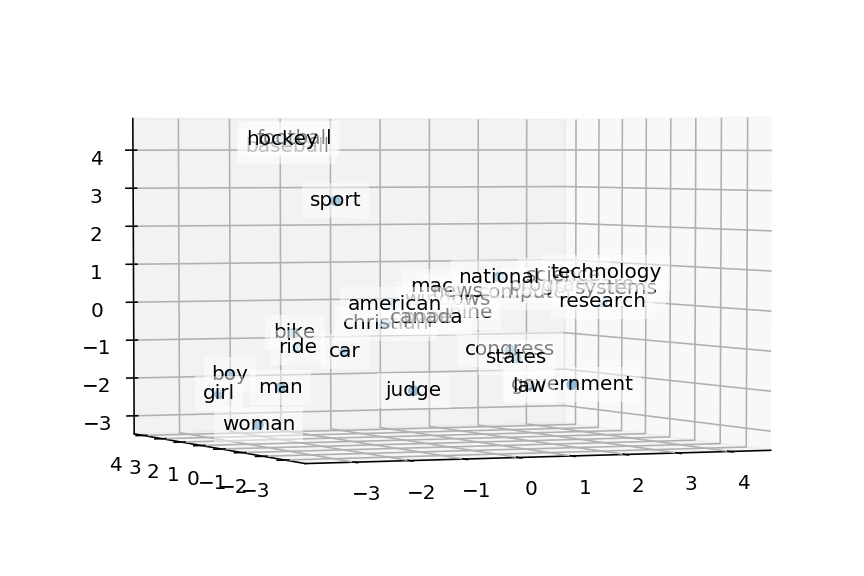

In [93]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
f = plt.figure()
ax = Axes3D(f)
#f, ax = plt.subplots(1, figsize = (16, 7))
ax.scatter(vector_map[:, 0], vector_map[:, 1], vector_map[:, 2])
for i, m in enumerate(vector_map):
    ax.text(m[0], m[1],m[2], words[i], ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.5, lw=0))

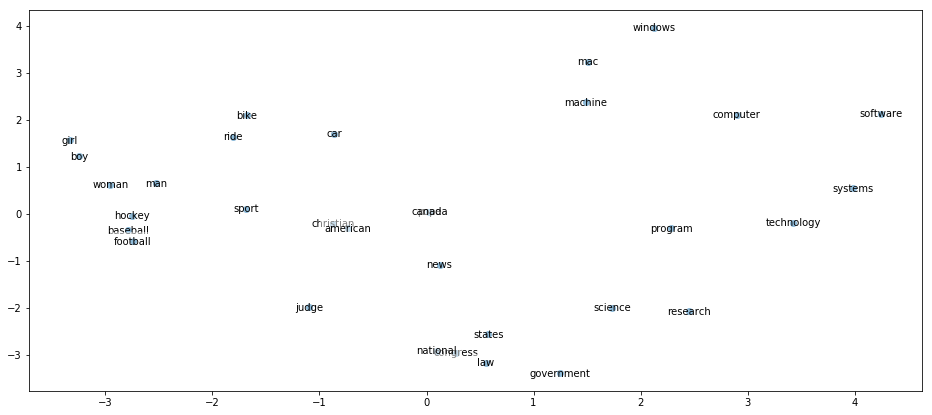

In [95]:
%matplotlib inline
f, ax = plt.subplots(1, figsize = (16, 7))
plt.scatter(vector_map[:, 0], vector_map[:, 1])
for i, m in enumerate(vector_map):
    plt.text(m[0], m[1], words[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))